# WGAN

元論文 : Wasserstein GAN https://arxiv.org/abs/1701.07875 (2017)

WGANはGANのLossを変えることで、数学的に画像生成の学習を良くしよう!っていうもの。

通常のGANはKLDivergenceを使って、Generatorによる確率分布を、生成したい画像の生起分布に近づけていく。だが、KLDでは連続性が保証されないので、代わりにWasserstain距離を用いて、近似していこうというのがWGAN。

Wasserstain距離によるLossを実現するために、WGANのDiscriminatorでは最後にSigmoid関数を適用しない。つまり、LossもSigmoid Cross Entropyでなく、Discriminatorの出力の値をそのまま使う。

WGANのアルゴリズムは、イテレーション毎に以下のDiscriminatorとGeneratorの学習を交互に行っていく。
- 最適化 : RMSProp(LearningRate:0.0005)

#### Discriminatorの学習（以下操作をcriticの数値だけ繰り返す）
1. Real画像と、一様分布からzをサンプリングする
2. Loss $L_D = \frac{1}{|Minibatch|} \{ \sum_{i} D(x^{(i)}) -  \sum_i D (G(z^{(i)})) \}$ を計算し、SGD
3. Discriminatorのパラメータを全て、 [- clip, clip]　にクリッピングする

#### Generatorの学習
1. 一様分布からzをサンプリングする
2. Loss $L_G = \frac{1}{|Minibatch|}  \sum_i D (G(z^{(i)})) $ を計算し、SGD

(WGANは収束がすごく遅い、、学習回数がめちゃくちゃ必要なので、注意！！！！)

## Import and Config

In [1]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from _main_base import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['akahara', 'madara'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_Z_DIM = 128
cfg.INPUT_MODE = None

cfg.OUTPUT_HEIGHT = 32
cfg.OUTPUT_WIDTH = 32
cfg.OUTPUT_CHANNEL = 3
cfg.OUTPUT_MODE = 'RGB'  # RGB, GRAY, EDGE, CLASS_LABEL

cfg.G_DIM = 64
cfg.D_DIM = 64

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = False
cfg.DEVICE = torch.device('cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu')

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'WGAN'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 5000
cfg.TRAIN.MINIBATCH = 32
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.LOSS_FUNCTION = None

cfg.TRAIN.DATA_PATH = './data/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = False # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = False # data augmentation : rotation False, or integer

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'

#---
# WGAN  config
#---
cfg.TRAIN.WGAN_CLIPS_VALUE = 0.01
cfg.TRAIN.WGAN_CRITIC_N = 5

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = './data'
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)


## Define Model

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'G_layer_1' : torch.nn.ConvTranspose2d(cfg.INPUT_Z_DIM, cfg.G_DIM * 4, kernel_size=[cfg.OUTPUT_HEIGHT // 8, cfg.OUTPUT_WIDTH // 8], stride=1, bias=False),
            'G_layer_1_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 4),
            'G_layer_1_ReLU' : torch.nn.ReLU(),
            'G_layer_2' : torch.nn.ConvTranspose2d(cfg.G_DIM * 4, cfg.G_DIM * 2, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_2_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 2),
            'G_layer_2_ReLU' : torch.nn.ReLU(),
            'G_layer_3' : torch.nn.ConvTranspose2d(cfg.G_DIM * 2, cfg.G_DIM, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_3_bn' : torch.nn.BatchNorm2d(cfg.G_DIM),
            'G_layer_3_ReLU' : torch.nn.ReLU(),
            'G_layer_out' : torch.nn.ConvTranspose2d(cfg.G_DIM, cfg.OUTPUT_CHANNEL, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_out_tanh' : torch.nn.Tanh()
        }))

    def forward(self, x):
        x = self.module(x)
        return x

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1' : torch.nn.Conv2d(cfg.OUTPUT_CHANNEL, cfg.D_DIM, kernel_size=4, padding=1, stride=2, bias=False),
            'D_layer_1_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            'D_layer_2' : torch.nn.Conv2d(cfg.D_DIM, cfg.D_DIM * 2, kernel_size=4, padding=1, stride=2, bias=False),
            'D_layer_2_bn' : torch.nn.BatchNorm2d(cfg.D_DIM * 2),
            'D_layer_2_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            'D_layer_3' : torch.nn.Conv2d(cfg.D_DIM * 2, cfg.D_DIM * 4, kernel_size=4, padding=1, stride=2, bias=False),
            'G_layer_3_bn' : torch.nn.BatchNorm2d(cfg.D_DIM * 4),
            'D_layer_3_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            'D_layer_out' : torch.nn.Conv2d(cfg.D_DIM * 4, 1, kernel_size=[cfg.OUTPUT_HEIGHT // 8, cfg.OUTPUT_WIDTH // 8], padding=0, stride=1, bias=False),
        }))

    def forward(self, x):
        x = self.module(x)
        return x

## Train

Files already downloaded and verified
training start
Iter:50, LossG (fake:0.3505), LossD:0.7016 (real:-0.3623, fake:0.3393), WDistance:-0.7016274333000183
Iter:100, LossG (fake:0.3378), LossD:0.6561 (real:-0.3374, fake:0.3187), WDistance:-0.6561057567596436
Iter:150, LossG (fake:0.3169), LossD:0.6249 (real:-0.3152, fake:0.3097), WDistance:-0.6249051094055176
Iter:200, LossG (fake:0.2962), LossD:0.5739 (real:-0.2957, fake:0.2782), WDistance:-0.5739462971687317
save G >> models/WGAN-GP_G_iter200.pt, D >> models/WGAN-GP_D_iter200.pt
Iter:250, LossG (fake:0.3003), LossD:0.5469 (real:-0.2822, fake:0.2648), WDistance:-0.5469043850898743
Iter:300, LossG (fake:0.2847), LossD:0.5567 (real:-0.2826, fake:0.2741), WDistance:-0.5567499399185181
Iter:350, LossG (fake:0.2797), LossD:0.5413 (real:-0.2862, fake:0.2551), WDistance:-0.5412789583206177
Iter:400, LossG (fake:0.2631), LossD:0.5034 (real:-0.2678, fake:0.2356), WDistance:-0.5034050345420837
save G >> models/WGAN-GP_G_iter400.pt, D >> models/W

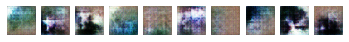

Iter:550, LossG (fake:0.2454), LossD:0.4834 (real:-0.2451, fake:0.2382), WDistance:-0.4833627939224243
Iter:600, LossG (fake:0.2570), LossD:0.4493 (real:-0.2502, fake:0.1991), WDistance:-0.4492908716201782
save G >> models/WGAN-GP_G_iter600.pt, D >> models/WGAN-GP_D_iter600.pt
Iter:650, LossG (fake:0.2549), LossD:0.4579 (real:-0.2258, fake:0.2321), WDistance:-0.45787206292152405
Iter:700, LossG (fake:0.2602), LossD:0.4632 (real:-0.2567, fake:0.2064), WDistance:-0.46315357089042664
Iter:750, LossG (fake:0.2380), LossD:0.4145 (real:-0.2438, fake:0.1707), WDistance:-0.41447025537490845
Iter:800, LossG (fake:0.2494), LossD:0.4245 (real:-0.2374, fake:0.1871), WDistance:-0.42449814081192017
save G >> models/WGAN-GP_G_iter800.pt, D >> models/WGAN-GP_D_iter800.pt
Iter:850, LossG (fake:0.2263), LossD:0.4284 (real:-0.2197, fake:0.2087), WDistance:-0.42841553688049316
Iter:900, LossG (fake:0.2146), LossD:0.4145 (real:-0.2139, fake:0.2006), WDistance:-0.41450315713882446
Iter:950, LossG (fake:0.24

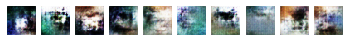

Iter:1050, LossG (fake:0.2387), LossD:0.3741 (real:-0.2227, fake:0.1515), WDistance:-0.3741452693939209
Iter:1100, LossG (fake:0.1364), LossD:0.3910 (real:-0.1760, fake:0.2150), WDistance:-0.39098578691482544
Iter:1150, LossG (fake:0.1790), LossD:0.3648 (real:-0.1893, fake:0.1755), WDistance:-0.36483120918273926
Iter:1200, LossG (fake:0.2009), LossD:0.3731 (real:-0.2122, fake:0.1609), WDistance:-0.37310200929641724
save G >> models/WGAN-GP_G_iter1200.pt, D >> models/WGAN-GP_D_iter1200.pt
Iter:1250, LossG (fake:0.1853), LossD:0.3842 (real:-0.2193, fake:0.1649), WDistance:-0.38422197103500366
Iter:1300, LossG (fake:0.2054), LossD:0.3960 (real:-0.2101, fake:0.1859), WDistance:-0.3959779739379883
Iter:1350, LossG (fake:0.1994), LossD:0.3768 (real:-0.2166, fake:0.1602), WDistance:-0.3768211007118225
Iter:1400, LossG (fake:0.1903), LossD:0.3050 (real:-0.2116, fake:0.0934), WDistance:-0.30501407384872437
save G >> models/WGAN-GP_G_iter1400.pt, D >> models/WGAN-GP_D_iter1400.pt
Iter:1450, Loss

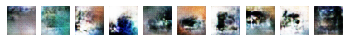

Iter:1550, LossG (fake:0.1347), LossD:0.3496 (real:-0.1496, fake:0.2000), WDistance:-0.3495907485485077
Iter:1600, LossG (fake:0.1686), LossD:0.3277 (real:-0.1553, fake:0.1724), WDistance:-0.32768499851226807
save G >> models/WGAN-GP_G_iter1600.pt, D >> models/WGAN-GP_D_iter1600.pt
Iter:1650, LossG (fake:0.2296), LossD:0.3558 (real:-0.2246, fake:0.1312), WDistance:-0.35580289363861084
Iter:1700, LossG (fake:0.1866), LossD:0.3415 (real:-0.1720, fake:0.1695), WDistance:-0.3415168225765228
Iter:1750, LossG (fake:0.1859), LossD:0.3959 (real:-0.2224, fake:0.1735), WDistance:-0.39589136838912964
Iter:1800, LossG (fake:0.1580), LossD:0.3198 (real:-0.1467, fake:0.1731), WDistance:-0.3197653293609619
save G >> models/WGAN-GP_G_iter1800.pt, D >> models/WGAN-GP_D_iter1800.pt
Iter:1850, LossG (fake:0.1409), LossD:0.3201 (real:-0.1475, fake:0.1726), WDistance:-0.3200942575931549
Iter:1900, LossG (fake:0.1522), LossD:0.3363 (real:-0.1678, fake:0.1686), WDistance:-0.33634665608406067
Iter:1950, LossG

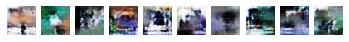

Iter:2050, LossG (fake:0.1663), LossD:0.3610 (real:-0.2005, fake:0.1605), WDistance:-0.3610071539878845
Iter:2100, LossG (fake:0.1964), LossD:0.2983 (real:-0.1958, fake:0.1025), WDistance:-0.29828882217407227
Iter:2150, LossG (fake:0.1158), LossD:0.3149 (real:-0.1788, fake:0.1361), WDistance:-0.31488102674484253
Iter:2200, LossG (fake:0.1795), LossD:0.3229 (real:-0.1609, fake:0.1620), WDistance:-0.32286950945854187
save G >> models/WGAN-GP_G_iter2200.pt, D >> models/WGAN-GP_D_iter2200.pt
Iter:2250, LossG (fake:0.2170), LossD:0.3091 (real:-0.1790, fake:0.1301), WDistance:-0.30906546115875244
Iter:2300, LossG (fake:0.1717), LossD:0.3402 (real:-0.1667, fake:0.1736), WDistance:-0.3402254581451416
Iter:2350, LossG (fake:0.1936), LossD:0.3301 (real:-0.1670, fake:0.1631), WDistance:-0.3301321566104889
Iter:2400, LossG (fake:0.1350), LossD:0.2403 (real:-0.1090, fake:0.1312), WDistance:-0.24026170372962952
save G >> models/WGAN-GP_G_iter2400.pt, D >> models/WGAN-GP_D_iter2400.pt
Iter:2450, Loss

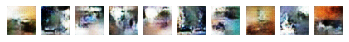

Iter:2550, LossG (fake:0.1958), LossD:0.3203 (real:-0.1940, fake:0.1263), WDistance:-0.3202798366546631
Iter:2600, LossG (fake:0.1959), LossD:0.3011 (real:-0.1865, fake:0.1147), WDistance:-0.30114856362342834
save G >> models/WGAN-GP_G_iter2600.pt, D >> models/WGAN-GP_D_iter2600.pt
Iter:2650, LossG (fake:0.1311), LossD:0.2888 (real:-0.1271, fake:0.1617), WDistance:-0.28880947828292847
Iter:2700, LossG (fake:0.1542), LossD:0.2577 (real:-0.1230, fake:0.1347), WDistance:-0.2577234208583832
Iter:2750, LossG (fake:0.1308), LossD:0.2937 (real:-0.1085, fake:0.1852), WDistance:-0.29366016387939453
Iter:2800, LossG (fake:0.1352), LossD:0.2801 (real:-0.1342, fake:0.1458), WDistance:-0.28008776903152466
save G >> models/WGAN-GP_G_iter2800.pt, D >> models/WGAN-GP_D_iter2800.pt
Iter:2850, LossG (fake:0.1338), LossD:0.2960 (real:-0.1243, fake:0.1717), WDistance:-0.2960028052330017
Iter:2900, LossG (fake:0.1333), LossD:0.3083 (real:-0.1530, fake:0.1553), WDistance:-0.30831190943717957
Iter:2950, Loss

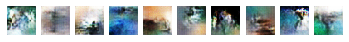

Iter:3050, LossG (fake:0.1613), LossD:0.3558 (real:-0.2100, fake:0.1457), WDistance:-0.35577648878097534
Iter:3100, LossG (fake:0.2109), LossD:0.3121 (real:-0.1824, fake:0.1297), WDistance:-0.31208714842796326
Iter:3150, LossG (fake:0.1526), LossD:0.2957 (real:-0.1688, fake:0.1269), WDistance:-0.29569754004478455
Iter:3200, LossG (fake:0.1298), LossD:0.2602 (real:-0.1148, fake:0.1454), WDistance:-0.2602289021015167
save G >> models/WGAN-GP_G_iter3200.pt, D >> models/WGAN-GP_D_iter3200.pt
Iter:3250, LossG (fake:0.1820), LossD:0.3268 (real:-0.1572, fake:0.1695), WDistance:-0.32676365971565247
Iter:3300, LossG (fake:0.1357), LossD:0.2609 (real:-0.1271, fake:0.1338), WDistance:-0.2609401345252991
Iter:3350, LossG (fake:0.1789), LossD:0.2663 (real:-0.1893, fake:0.0770), WDistance:-0.2662712633609772
Iter:3400, LossG (fake:0.1932), LossD:0.2761 (real:-0.1584, fake:0.1177), WDistance:-0.2760627865791321
save G >> models/WGAN-GP_G_iter3400.pt, D >> models/WGAN-GP_D_iter3400.pt
Iter:3450, LossG

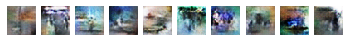

Iter:3550, LossG (fake:0.1674), LossD:0.2533 (real:-0.1582, fake:0.0952), WDistance:-0.2533412575721741
Iter:3600, LossG (fake:0.1595), LossD:0.2399 (real:-0.1490, fake:0.0910), WDistance:-0.23993653059005737
save G >> models/WGAN-GP_G_iter3600.pt, D >> models/WGAN-GP_D_iter3600.pt
Iter:3650, LossG (fake:0.1727), LossD:0.2968 (real:-0.1447, fake:0.1521), WDistance:-0.29679596424102783
Iter:3700, LossG (fake:0.1058), LossD:0.2883 (real:-0.1384, fake:0.1498), WDistance:-0.2882733941078186
Iter:3750, LossG (fake:0.1489), LossD:0.3170 (real:-0.1703, fake:0.1466), WDistance:-0.3169509768486023
Iter:3800, LossG (fake:0.1803), LossD:0.3062 (real:-0.1783, fake:0.1279), WDistance:-0.30624985694885254
save G >> models/WGAN-GP_G_iter3800.pt, D >> models/WGAN-GP_D_iter3800.pt
Iter:3850, LossG (fake:0.1587), LossD:0.2587 (real:-0.1234, fake:0.1353), WDistance:-0.25865498185157776
Iter:3900, LossG (fake:0.1685), LossD:0.2863 (real:-0.1662, fake:0.1201), WDistance:-0.2863123416900635
Iter:3950, LossG

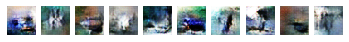

Iter:4050, LossG (fake:0.2000), LossD:0.3051 (real:-0.1936, fake:0.1116), WDistance:-0.30512070655822754
Iter:4100, LossG (fake:0.1856), LossD:0.2409 (real:-0.1736, fake:0.0673), WDistance:-0.24086494743824005
Iter:4150, LossG (fake:0.1177), LossD:0.2258 (real:-0.1028, fake:0.1230), WDistance:-0.2257911115884781
Iter:4200, LossG (fake:0.1093), LossD:0.2318 (real:-0.0837, fake:0.1481), WDistance:-0.2318018674850464
save G >> models/WGAN-GP_G_iter4200.pt, D >> models/WGAN-GP_D_iter4200.pt
Iter:4250, LossG (fake:0.1781), LossD:0.2852 (real:-0.1679, fake:0.1173), WDistance:-0.2851703464984894
Iter:4300, LossG (fake:0.1211), LossD:0.2455 (real:-0.1360, fake:0.1096), WDistance:-0.24554604291915894
Iter:4350, LossG (fake:0.1582), LossD:0.2554 (real:-0.1283, fake:0.1271), WDistance:-0.255389004945755
Iter:4400, LossG (fake:0.1827), LossD:0.2850 (real:-0.1492, fake:0.1358), WDistance:-0.2850188612937927
save G >> models/WGAN-GP_G_iter4400.pt, D >> models/WGAN-GP_D_iter4400.pt
Iter:4450, LossG (

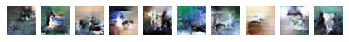

Iter:4550, LossG (fake:0.1337), LossD:0.2547 (real:-0.1847, fake:0.0700), WDistance:-0.2546800673007965
Iter:4600, LossG (fake:0.1613), LossD:0.2766 (real:-0.1418, fake:0.1348), WDistance:-0.27660292387008667
save G >> models/WGAN-GP_G_iter4600.pt, D >> models/WGAN-GP_D_iter4600.pt
Iter:4650, LossG (fake:0.1653), LossD:0.2729 (real:-0.1630, fake:0.1099), WDistance:-0.27291804552078247
Iter:4700, LossG (fake:0.1677), LossD:0.3148 (real:-0.1851, fake:0.1297), WDistance:-0.3147921562194824
Iter:4750, LossG (fake:0.1979), LossD:0.2235 (real:-0.1662, fake:0.0573), WDistance:-0.223517045378685
Iter:4800, LossG (fake:0.1528), LossD:0.2460 (real:-0.1560, fake:0.0899), WDistance:-0.2459503710269928
save G >> models/WGAN-GP_G_iter4800.pt, D >> models/WGAN-GP_D_iter4800.pt
Iter:4850, LossG (fake:0.1155), LossD:0.2844 (real:-0.1376, fake:0.1467), WDistance:-0.2843594253063202
Iter:4900, LossG (fake:0.1337), LossD:0.2502 (real:-0.1364, fake:0.1138), WDistance:-0.2502034604549408
Iter:4950, LossG (f

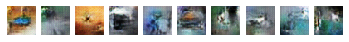

final paramters were saved to G >> models/WGAN-GP_G_final.pt, D >> models/WGAN-GP_D_final.pt
loss was saved to >> result/WGAN-GP_loss.txt


In [3]:
def result_show(G, z, path=None, save=False, show=False):
    if (save or show) is False:
        print('argument save >> {} and show >> {}, so skip')
        return

    Gz = G(z)
    Gz = Gz.detach().cpu().numpy()

    Gz = (Gz * 127.5 + 127.5).astype(np.uint8)
    Gz = Gz.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    Gz = Gz.transpose(0, 2, 3, 1)

    for i in range(cfg.TEST.MINIBATCH):
        _G = Gz[i]
        plt.subplot(1, cfg.TEST.MINIBATCH, i + 1)
        plt.imshow(_G)
        plt.axis('off')

    if path is not None:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()

# train
def train():
    # model
    G = Generator().to(cfg.DEVICE)
    D = Discriminator().to(cfg.DEVICE)

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    trainset = torchvision.datasets.CIFAR10(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    train_Xs = trainset.data
    train_ys = trainset.targets

    # training
    mbi = 0
    train_N = len(train_Xs)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []
    list_loss_WDistance = []

    one = torch.FloatTensor([1])
    minus_one = one * -1

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # update D
        for _ in range(cfg.TRAIN.WGAN_CRITIC_N):
            opt_D.zero_grad()

            # parameter clipping > [-clip_value, clip_value]
            for param in D.parameters():
                param.data.clamp_(- cfg.TRAIN.WGAN_CLIPS_VALUE, cfg.TRAIN.WGAN_CLIPS_VALUE)

            # sample X
            Xs = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.OUTPUT_MODE), dtype=torch.float).to(cfg.DEVICE)

            # sample x
            z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            # forward
            Gz = G(z)
            loss_D_fake = D(Gz).mean(0).view(1)
            loss_D_real = D(Xs).mean(0).view(1)
            loss_D = loss_D_fake - loss_D_real
            loss_D_real.backward(one)
            loss_D_fake.backward(minus_one)
            opt_D.step()
            Wasserstein_distance = loss_D_real - loss_D_fake

        # update G
        opt_G.zero_grad()
        z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)
        loss_G = D(G(z)).mean(0).view(1)
        loss_G.backward(one)
        opt_G.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_G = loss_G.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()
        _Wasserstein_distance = Wasserstein_distance.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)
                list_loss_WDistance.append(_Wasserstein_distance)
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG (fake:{:.4f}), LossD:{:.4f} (real:{:.4f}, fake:{:.4f}), WDistance:{:.4f}'.format(
                i + 1, _loss_G, _loss_D, _loss_D_real, _loss_D_fake, _Wasserstein_distance))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                G, z, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True)

    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_D' : list_loss_D, 
                            'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake, 'Wasserstein_Distance' : list_loss_WDistance})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

--------------------
test function
--------------------
result was saved to >> result/WGAN-GP_result_1.jpg


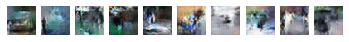

result was saved to >> result/WGAN-GP_result_2.jpg


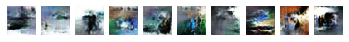

In [4]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    np.random.seed(0)
    
    for i in range(cfg.TEST.ITERATION):
        z = np.random.uniform(-1, 1, size=(cfg.TEST.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

        result_show(G, z, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), save=cfg.TEST.RESULT_SAVE, show=True)

test()

In [ ]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
